# Accessing the project directory on my Google Drive  

In [1]:
import os
from google.colab import drive

drive.mount('/drive', force_remount=False)
project_dir = "/drive/My Drive/RNNSeq2Seq/"

# change working directory to project_dir
os.chdir(project_dir)

Mounted at /drive


# Dependencies

In [2]:
from scripts.model import *
from scripts.dataloader import create_dataloader
from scripts.utils import *
from scripts.pytorch_utils import *
import matplotlib.pyplot as plt

# Helper function to help visualize 

In [3]:
def plot_log(log):
    len_range = len(log) -1 if "Best eval accu" in log else len(log)
    epoch_nums, train_loss, dev_loss = [], [], []
    train_acc, dev_acc = [], []

    for epoch in range(1, len_range+1):
        epoch_nums.append(epoch)
        train = log[f"Epoch#{epoch}"]["Train"]
        dev = log[f"Epoch#{epoch}"]["Eval"]
        train_loss.append(train['loss'])
        train_acc.append(train['abosulate accuracy'])

        dev_loss.append(dev['loss'])
        dev_acc.append(dev['abosulate accuracy'])

    ax1 = plt.subplot(211)
    ax1.plot(epoch_nums, train_loss, label="train loss")
    ax1.plot(epoch_nums, dev_loss, label="dev loss")
    ax1.legend()

    ax2 = plt.subplot(212)
    ax2.plot(epoch_nums, train_acc, label="train acc")
    ax2.plot(epoch_nums, dev_acc, label="dev acc")
    ax2.legend()
    plt.show()

In [4]:
folder = "tuning_data/"
experiment_num = 8
shuffle_batch = True

# must be the num of seq per seq length if shuffle_batch is False
# this "tr_batch_size" will be used for dev, and shuffled test sets
tr_batch_size = 250 
dev_batch_size = 500 if not shuffle_batch else tr_batch_size

In [5]:
# setups for training and evaluting

print_freq = 5
acc_threshold = 0.5 # for saving the best trained models 
max_epoch_num = 150 # max num of epoches 
train_acc_exit=0.92 # train acc exit threshold (eval_acc_exit must also be met)
eval_acc_exit=0.92 # dev acc exit threshold (train_acc_exit must also be met)
teacher_forcing_ratio = 1.0 # probability of using real symbol from target sequence for training

# RevStr

In [24]:
train = read_data(join(folder, "RevStr/train.txt"))
dev = read_data(join(folder, "RevStr/dev.txt"))
saved_model_fp = join(project_dir, "notebooks/Hyperparatemers Tuning/RevStr_model.pt")

train_dl = create_dataloader(train, batch_size=tr_batch_size, shuffle=shuffle_batch)
dev_dl = create_dataloader(dev, batch_size=dev_batch_size, shuffle=shuffle_batch)

## Hyperparameter set 1

In [7]:
in_vocab = ascii_lowercase
out_vocab = ascii_lowercase
in_vocab_size = len(in_vocab) + 2
out_vocab_size = len(out_vocab) + 2

hidden_size = 512
embd_dim = 256
num_layers = 1
rnn_type = "GRU"
dropout_rate = 0.0
bidirectional = False
use_attention = False
reduction_method = torch.sum

learning_rate = 5e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [8]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 1.9487575948238374, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.009828333393670619, 'overlap rate': 0.4317583777010441}
evaluation performance: {'loss': 3.7216471999883654, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0077133334008976815, 'overlap rate': 0.3696367029100657}

Current epoch: 10, 
training performance: {'loss': 1.6797687232494354, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.007641666708514095, 'overlap rate': 0.49329504892230036}
evaluation performance: {'loss': 2.1701477214694025, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.007941059424774721, 'overlap rate': 0.47451107427477834}

Current epoch: 15, 
training performance: {'loss': 1.3014185100793838, 'abosulate accuracy': 0.00010000000474974513, 'consecutive overlap rate': 0.01831833350006491, 'overlap rate': 0.5851500615477562}
evaluation performance: {'loss': 1.7056970760226249, 'abosulate accuracy': 0.00010000000474974

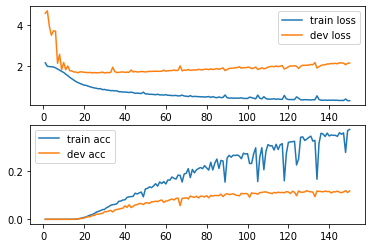

In [9]:
plot_log(log)

## Hyperparameter set 2

In [10]:
hidden_size = 256
embd_dim = 256
num_layers = 1
rnn_type = "GRU"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 1.9198986887931824, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.005478333414066583, 'overlap rate': 0.44008671417832373}
evaluation performance: {'loss': 2.8227059215307237, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0038124152953969313, 'overlap rate': 0.44835089072585105}

Current epoch: 10, 
training performance: {'loss': 1.8170296221971511, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.004491666710237041, 'overlap rate': 0.4649833798408508}
evaluation performance: {'loss': 2.2675916731357573, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0045491667027818036, 'overlap rate': 0.46507171280682086}

Current epoch: 15, 
training performance: {'loss': 1.7029007971286774, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.005970000091474503, 'overlap rate': 0.4896700456738472}
evaluation performance: {'loss': 1.772903646528721, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0

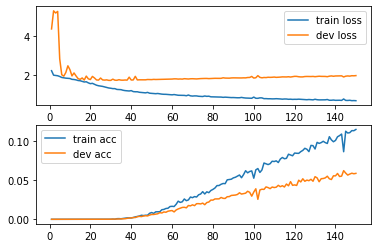

In [12]:
plot_log(log)

## Hyperparameter set 3

In [13]:
hidden_size = 512
embd_dim = 256
num_layers = 1
rnn_type = "GRU"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 1.9915417551994323, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0007250000147905666, 'overlap rate': 0.4216700419783592}
evaluation performance: {'loss': 4.001266026496888, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0007541666862380225, 'overlap rate': 0.42267337441444397}

Current epoch: 10, 
training performance: {'loss': 1.9291621387004851, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0007816666839062236, 'overlap rate': 0.42833504304289816}
evaluation performance: {'loss': 2.2834376215934755, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0007200000156444731, 'overlap rate': 0.42780087925493715}

Current epoch: 15, 
training performance: {'loss': 1.9136693805456162, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0007383333460893482, 'overlap rate': 0.42971337884664534}
evaluation performance: {'loss': 1.952620653808117, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 

## Hyperparameter set 4

In [15]:
hidden_size = 512
embd_dim = 512
num_layers = 1
rnn_type = "GRU"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 1.7857222646474837, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.004956666717771441, 'overlap rate': 0.468270044028759}
evaluation performance: {'loss': 2.2565004378557205, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.005213333404390142, 'overlap rate': 0.47173421606421473}

Current epoch: 10, 
training performance: {'loss': 1.386787047982216, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.016436666855588554, 'overlap rate': 0.5607000604271889}
evaluation performance: {'loss': 1.9552783355116845, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.01736916694790125, 'overlap rate': 0.48305088356137277}

Current epoch: 15, 
training performance: {'loss': 1.0455625921487808, 'abosulate accuracy': 0.0074000002583488825, 'consecutive overlap rate': 0.042215000558644536, 'overlap rate': 0.650340062379837}
evaluation performance: {'loss': 1.6704664081335068, 'abosulate accuracy': 0.005200000223703682, 'c

## Hyperparameter set 5

In [25]:
hidden_size = 512
embd_dim = 256
num_layers = 1
rnn_type = "GRU"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 1.9588103681802749, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0006783333476050757, 'overlap rate': 0.4242350451648235}
evaluation performance: {'loss': 2.348623526096344, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0007116666802176042, 'overlap rate': 0.39984420873224735}

Current epoch: 10, 
training performance: {'loss': 1.9285414069890976, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.001353333353472408, 'overlap rate': 0.4377117119729519}
evaluation performance: {'loss': 2.4489706426858904, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0014008333600941114, 'overlap rate': 0.42370004393160343}

Current epoch: 15, 
training performance: {'loss': 1.783800095319748, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0046533333661500365, 'overlap rate': 0.4812667168676853}
evaluation performance: {'loss': 2.2285499304533003, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0

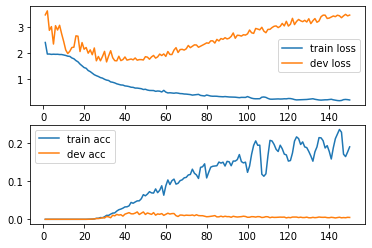

In [27]:
plot_log(log)

# RedStr



In [17]:
train = read_data(join(folder, "RedStr/train.txt"))
dev = read_data(join(folder, "RedStr/dev.txt"))
saved_model_fp = join(project_dir, "notebooks/Hyperparatemers Tuning/RevStr_model.pt")

train_dl = create_dataloader(train, batch_size=tr_batch_size, shuffle=shuffle_batch)
dev_dl = create_dataloader(dev, batch_size=dev_batch_size, shuffle=shuffle_batch)

## Hyperparameter set 1


In [18]:
hidden_size = 512
embd_dim = 512
num_layers = 1
rnn_type = "GRU"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 1.9519832283258438, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0006416666772565804, 'overlap rate': 0.4249967083334923}
evaluation performance: {'loss': 2.5104337096214295, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0006791666826757136, 'overlap rate': 0.4283042125403881}

Current epoch: 10, 
training performance: {'loss': 1.9505242586135865, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0007053448440274224, 'overlap rate': 0.4275746397674084}
evaluation performance: {'loss': 2.6837437450885773, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0006916666821780382, 'overlap rate': 0.42773087657988074}

Current epoch: 15, 
training performance: {'loss': 1.966446989774704, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0007816666839062236, 'overlap rate': 0.4185750424861908}
evaluation performance: {'loss': 2.759652689099312, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0

## Hyperparameter set 2

In [20]:
hidden_size = 512
embd_dim = 256
num_layers = 1
rnn_type = "GRU"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 1.9529551297426224, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0007100000126229134, 'overlap rate': 0.42456004321575164}
evaluation performance: {'loss': 3.713158068060875, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0007116666833098861, 'overlap rate': 0.4259975429624319}

Current epoch: 10, 
training performance: {'loss': 1.9258649319410324, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0009466666881053243, 'overlap rate': 0.4329883813858032}
evaluation performance: {'loss': 2.4847760438919066, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0010600000248814467, 'overlap rate': 0.4327833779156208}

Current epoch: 15, 
training performance: {'loss': 1.9155310839414597, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0012683333639870397, 'overlap rate': 0.43555337861180304}
evaluation performance: {'loss': 2.3015499264001846, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0

## Hyperparameter set 3

In [22]:
hidden_size = 512
embd_dim = 256
num_layers = 1
rnn_type = "GRU"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 1.844345933198929, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.002538333350094035, 'overlap rate': 0.45460004135966303}
evaluation performance: {'loss': 2.5548785477876663, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0030033333867322655, 'overlap rate': 0.4473058771342039}

Current epoch: 10, 
training performance: {'loss': 1.4827395051717758, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.018271666904911398, 'overlap rate': 0.5414934009313583}
evaluation performance: {'loss': 2.4352600395679476, 'abosulate accuracy': 5.0000002374872565e-05, 'consecutive overlap rate': 0.0207183335442096, 'overlap rate': 0.4732817132025957}

Current epoch: 15, 
training performance: {'loss': 1.1246950268745421, 'abosulate accuracy': 0.0012000000569969416, 'consecutive overlap rate': 0.04497500052675605, 'overlap rate': 0.6322117254137993}
evaluation performance: {'loss': 1.9091710954904557, 'abosulate accuracy': 0.000